<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
code = '005930'
start_date = '20000101'
end_date = '20220301'
# freq: day, week, month

periods = 120
sample_num = 1000

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import ast
import re

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_info(self):
    url = 'https://finance.naver.com/item/main.naver?code=' + code
    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    cap = bs_obj.find_all('table', {'summary':'시가총액 정보'})[0].find('td').text
    cap = int(''.join(re.findall("\d+", cap)))
    pbr = float(bs_obj.find_all('table', {'summary':'PER/EPS 정보'})[0].find_all('em', {'id':"_pbr"})[0].text)
    per = bs_obj.find_all('table', {'summary':'PER/EPS 정보'})[0].find('td').text[:15]
    per = float(re.findall("\d+\.\d+", per)[0])
    sector_per = bs_obj.find_all('table', {'summary':'동일업종 PER 정보'})[0].find('td').text[:15]
    sector_per = float(re.findall("\d+\.\d+", sector_per)[0])
    return {'cap': cap, 'pbr': pbr, 'per': per, 'sector_per': sector_per}

  def get_price(self, start='20180501', interval='day'):
    url ='https://api.finance.naver.com/siseJson.naver?symbol=' + self.code + '&requestType=1&startTime=' \
    + start + '&endTime=' + str(datetime.datetime.now().date().strftime("%Y%m%d")) + '&timeframe=' + interval
    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    b = bs_obj.get_text()
    for i in ['\n', '\t', "\\", ' ']:
      b = b.replace(i,'')

    data = np.array(ast.literal_eval(b)[1:])

    dic = {'Date':list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'), data[:,0])), \
      'Open':np.array(data[:,1], float), 'High':np.array(data[:,2], float), 'Low':np.array(data[:,3], float),\
       'Close':np.array(data[:,4], float), 'Volume':np.array(data[:,5], float)}

    df = pd.DataFrame(data=dic)
    df = df.set_index('Date')
    df['Change'] = df['Close'][1:]/df['Close'][:-1].values
    df = df[1:]
    return df

In [3]:
e = datetime.datetime.strptime(end_date, '%Y%m%d')

stock = Stock(code)
df = stock.get_price(start_date)
test_df = df[:e]

Monte Carlo Simulation

In [4]:
from datetime import datetime, date
import random
import math

m = test_df['Change'][-periods:].mean()
var = test_df['Change'][-periods:].var()

dates = df[df.index > end_date].index[:periods]
close_li = [pd.DataFrame({'Change':[random.gauss(m, math.sqrt(var)) for i in range(periods)]}, index=dates) for x in range(sample_num)]
close_li = list(map(lambda x: np.cumprod(x).rename(columns={'Change':'Close'}) * test_df['Close'][-1], close_li))

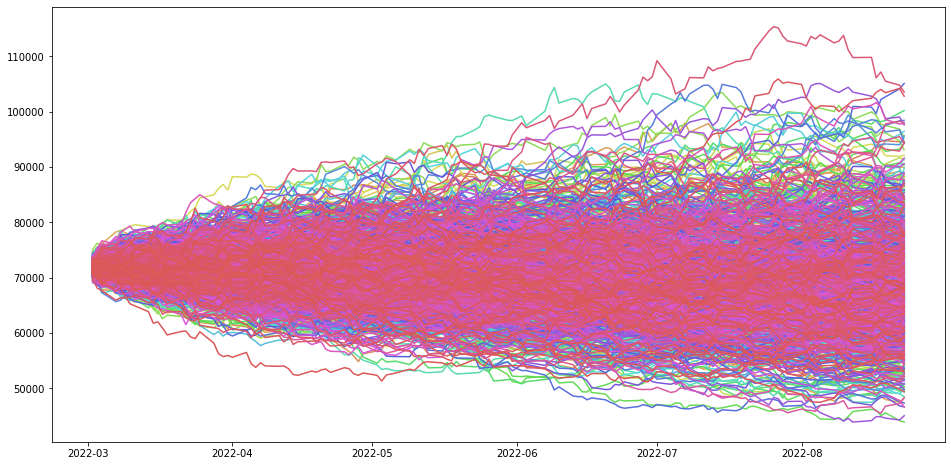

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
colors = list(sns.color_palette("hls", sample_num).as_hex())

for i, j in enumerate(close_li):
  ax.plot(j['Close'], color=colors[i]) #, label=i+1)

plt.show()

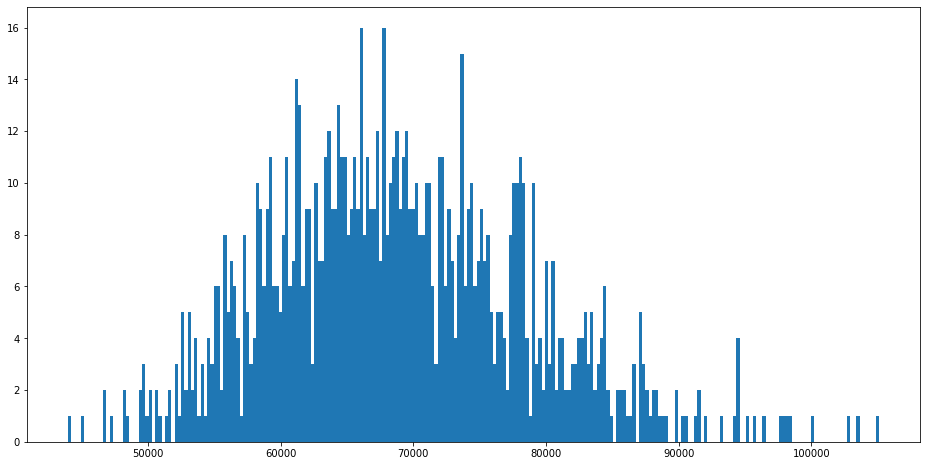

In [6]:
plt.figure(figsize=(16, 8))
end_data = [x.iloc[-1].values[0] for x in close_li]
plt.hist(end_data, bins=250)
plt.show()

In [7]:
# 95% 신뢰구간
max95 = np.mean(end_data) + (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
min95 = np.mean(end_data) - (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
print('95% Min: ', round(min95))
print('95% Max: ', round(max95))

# 평균
monte_mean = np.mean([round(x.iloc[-1].values[0],0) for x in close_li])
print('Mean: ', monte_mean)

# 중앙
monte_median = np.median([round(x.iloc[-1].values[0],0) for x in close_li])
print('Median: ', monte_median)

95% Min:  68290
95% Max:  69494
Mean:  68891.901
Median:  68110.0


In [8]:
monte_date = close_li[0].index[-1]

Circular Block Bootstrap

In [9]:
block = round(periods ** (1/2))
data = list(test_df['Change'][-periods:].values)
ccb = [(data+data[:block])[x:block+x] for x in range(len(data))]

In [10]:
import random

change = [j for sub in random.sample(ccb, int(periods/block)) for j in sub]

periods = len(change)
dates = df[df.index > end_date].index[:periods]
close_li = [pd.DataFrame({'Change':[j for sub in random.sample(ccb, int(periods/block)) for j in sub]}, index=dates) for x in range(sample_num)]
close_li = list(map(lambda x: np.cumprod(x).rename(columns={'Change':'Close'}) * test_df['Close'][-1], close_li))

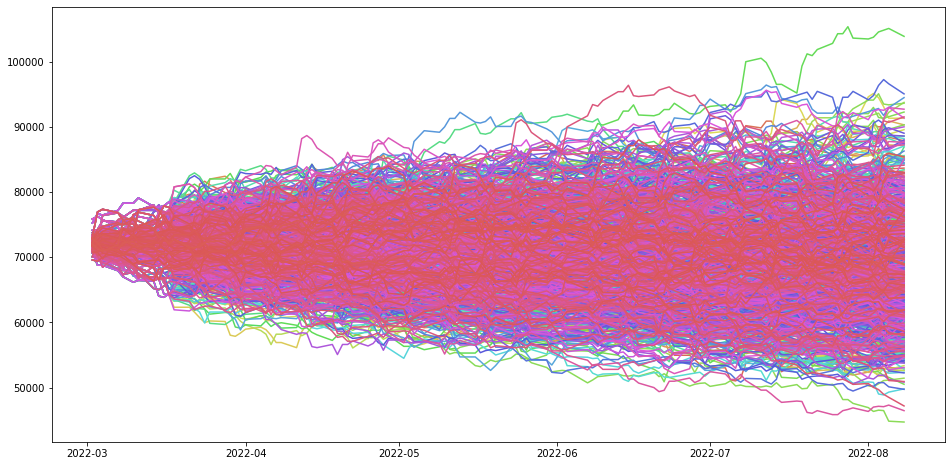

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
colors = list(sns.color_palette("hls", sample_num).as_hex())

for i, j in enumerate(close_li):
  ax.plot(j['Close'], color=colors[i]) #, label=i+1)

plt.show()

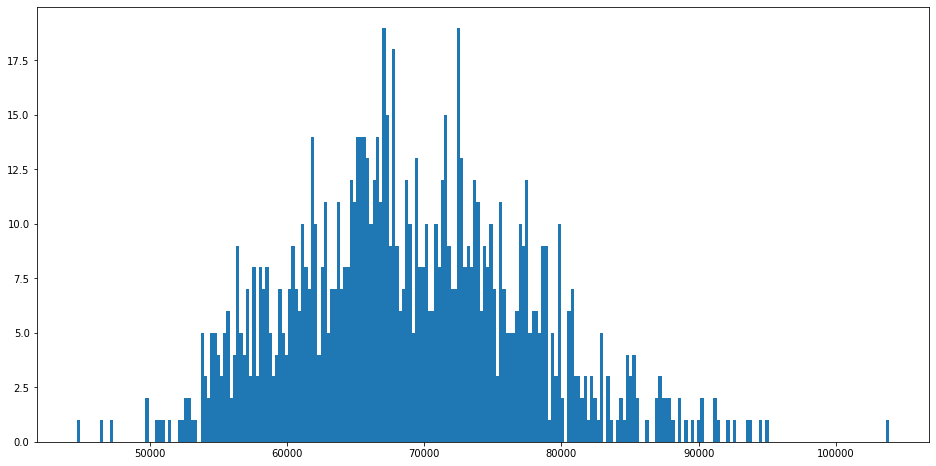

In [12]:
plt.figure(figsize=(16, 8))
end_data = [x.iloc[-1].values[0] for x in close_li]
plt.hist(end_data, bins=250)
plt.show()

In [13]:
# 95% 신뢰구간
max95 = np.mean(end_data) + (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
min95 = np.mean(end_data) - (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
print('95% Min: ', round(min95))
print('95% Max: ', round(max95))

# 평균
ccb_mean =  np.mean([round(x.iloc[-1].values[0],0) for x in close_li])
print('Mean: ', ccb_mean)

# 중앙
ccb_median = np.median([round(x.iloc[-1].values[0],0) for x in close_li])
print('Median: ', ccb_median)

95% Min:  68367
95% Max:  69416
Mean:  68891.29
Median:  68122.0


In [14]:
ccb_date = close_li[0].index[-1]

In [15]:
monte_date

Timestamp('2022-08-23 00:00:00')

In [16]:
ccb_date

Timestamp('2022-08-08 00:00:00')

In [17]:
print('Min: ', min(monte_median, ccb_median))
print('Max: ', max(monte_median, ccb_median))

Min:  68110.0
Max:  68122.0
